In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import os
import warnings
from utils import general_overview
file_path = "../data/processed-data/madrid_housing_sale_preprocessed.parquet"

df = pd.read_parquet(file_path, engine='pyarrow')

LET US TAKE A FIRST LOOK AT THE DATASET

In [46]:
general_overview(df)

Column Name                              | Type       | Missing         | Unique     | Sample Values
--------------------------------------------------------------------------------------------------------------
reference_id                             | int64      | 0 (0.0%)        | 62671      | 175162, 315919, 332409
n_rooms                                  | float64    | 2892 (4.0%)     | 22         | 2.0, 3.0, 0.0
n_baths                                  | float64    | 1872 (2.6%)     | 22         | 2.0, 1.0, 3.0
area                                     | float64    | 968 (1.3%)      | 1114       | 201.0, 92.0, 70.0
floor                                    | float64    | 16467 (22.9%)   | 29         | 3.0, 1.0, 5.0
has_elevator                             | int32      | 0 (0.0%)        | 2          | 1, 0
has_terrace                              | int32      | 0 (0.0%)        | 2          | 1, 0
is_exterior                              | int32      | 0 (0.0%)        | 2          |

WE SPLIT THE DATASET BASING ON THE PROPERTY TYPE

In [47]:
property_cols = [
    'property_type_edificios',
    'property_type_garajes',
    'property_type_habitacion',
    'property_type_locales',
    'property_type_oficinas',
    'property_type_terrenos',
    'property_type_trasteros',
    'property_type_vivienda'
]
#we create a dictionary for the split datasets
dfs = {}

for col in property_cols:
    type_name = col.replace('property_type_', '')
    dfs[type_name] = df[df[col] == 1].copy()
    dfs[type_name] = dfs[type_name].drop(columns=property_cols)

df_vivienda = dfs['vivienda']
df_garajes = dfs['garajes']
df_locales = dfs['locales']
df_oficinas = dfs['oficinas']
df_terrenos = dfs['terrenos']
df_trasteros = dfs['trasteros']
df_edificios = dfs['edificios']

print(f"{'Type':<15} | {'Rows':<10} | {'Cols':<5}")
print("-" * 35)
for key, data in dfs.items():
    print(f"{key:<15} | {len(data):<10} | {data.shape[1]:<5}")

Type            | Rows       | Cols 
-----------------------------------
edificios       | 40         | 26   
garajes         | 1264       | 26   
habitacion      | 0          | 26   
locales         | 914        | 26   
oficinas        | 110        | 26   
terrenos        | 324        | 26   
trasteros       | 22         | 26   
vivienda        | 69124      | 26   


WE SAVE ALL DATASETS FOR FUTURE PURPOSES

In [48]:


# Define output directory
output_folder = '../data/processed-data'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print(f"--- SAVING SUPPLEMENTARY ASSET DATASETS (Excluding Vivienda) ---")

# Iterate and save everything EXCEPT 'vivienda'
for key, data in dfs.items():
    # 1. Skip the main residential dataset
    if key == 'vivienda':
        continue
        
    # 2. Save the others if they have data
    if not data.empty:
        filename = f"{output_folder}/madrid_{key}_sales.parquet"
        data.to_parquet(filename, index=False)
        print(f" Saved {key.upper():<10} -> {filename} ({len(data)} rows)")
    else:
        print(f" Skipped {key.upper():<10} -> Empty dataframe")

print("\nDONE. Supplementary datasets are ready.")

--- SAVING SUPPLEMENTARY ASSET DATASETS (Excluding Vivienda) ---
 Saved EDIFICIOS  -> ../data/processed-data/madrid_edificios_sales.parquet (40 rows)
 Saved GARAJES    -> ../data/processed-data/madrid_garajes_sales.parquet (1264 rows)
 Skipped HABITACION -> Empty dataframe
 Saved LOCALES    -> ../data/processed-data/madrid_locales_sales.parquet (914 rows)
 Saved OFICINAS   -> ../data/processed-data/madrid_oficinas_sales.parquet (110 rows)
 Saved TERRENOS   -> ../data/processed-data/madrid_terrenos_sales.parquet (324 rows)
 Saved TRASTEROS  -> ../data/processed-data/madrid_trasteros_sales.parquet (22 rows)

DONE. Supplementary datasets are ready.


WE WILL START ANALYZING THE "VIVIENDA" DATASET

WE HAVE TO DEAL WITH THE ID PROBLEM

In [49]:

df_vivienda = df_vivienda.sort_values(by=['reference_id', 'year', 'month'])

history_stats = df_vivienda.groupby('reference_id').agg({
    'price': ['first', 'count', 'std', 'nunique'],
    'year': 'first',
    'month': 'first'
})


history_stats.columns = ['initial_price', 'observations', 'price_volatility', 'num_price_changes', 'initial_year', 'initial_month']

history_stats['price_volatility'] = history_stats['price_volatility'].fillna(0)

df_vivienda_featured = df_vivienda.drop_duplicates(subset='reference_id', keep='last').copy()

df_vivienda_featured = df_vivienda_featured.merge(history_stats, on='reference_id', how='left')

#SMALL FEATURE ENGINEERING
df_vivienda_featured['price_variation'] = (df_vivienda_featured['price'] - df_vivienda_featured['initial_price']) / df_vivienda_featured['initial_price']
df_vivienda_featured['months_on_market'] = (df_vivienda_featured['year'] - df_vivienda_featured['initial_year']) * 12 + (df_vivienda_featured['month'] - df_vivienda_featured['initial_month'])

print(f"Featured Data Shape: {df_vivienda_featured.shape}")
print("-" * 30)
cols_to_check = ['price', 'initial_price', 'price_variation', 'observations', 'price_volatility', 'num_price_changes', 'initial_year','year', 'initial_month', 'month']
print(df_vivienda_featured[cols_to_check].head())

Featured Data Shape: (59998, 34)
------------------------------
      price  initial_price  price_variation  observations  price_volatility  \
0  795000.0       795000.0         0.000000             1          0.000000   
1  475000.0       475000.0         0.000000             1          0.000000   
2  180000.0       180000.0         0.000000             1          0.000000   
3  485000.0       450000.0         0.077778             3      18027.756377   
4  298000.0       298000.0         0.000000             1          0.000000   

   num_price_changes  initial_year  year  initial_month  month  
0                  1          2025  2025              2      2  
1                  1          2024  2024              2      2  
2                  1          2024  2024              3      3  
3                  3          2024  2024              3     10  
4                  1          2025  2025              2      2  


Now we have unique IDs so we can run some statistics in the dataset.

Before doing that, we organize features in the dataset

In [50]:
identity_cols = ['reference_id']

market_cols = [
    'price', 'initial_price', 'price_down_from', 'price_variation', 
    'price_volatility', 'num_price_changes', 'observations'
]

temporal_cols = [
    'year', 'month', 'initial_year', 'initial_month', 'months_on_market'
]

structural_cols = [
    'area', 'n_rooms', 'n_baths', 'floor', 'property_state_score'
]

amenities_cols = [
    'has_elevator', 'has_terrace', 'is_exterior', 'has_swimming_pool', 
    'has_parking', 'has_garden', 'has_floorplan', 'has_virtual_tour', 'n_videos'
]

location_cols = ['latitude', 'longitude', 'approximate_location']

energy_cols = [col for col in df_vivienda_featured.columns if 'energy' in col]

new_order = identity_cols + market_cols + temporal_cols + structural_cols + amenities_cols + location_cols + energy_cols

df_vivienda_featured = df_vivienda_featured[new_order]

print("Columns reorganized by logical domain.")
print(df_vivienda_featured.head())

Columns reorganized by logical domain.
   reference_id     price  initial_price  price_down_from  price_variation  \
0        175162  795000.0       795000.0              NaN         0.000000   
1        315919  475000.0       475000.0              NaN         0.000000   
2        332409  180000.0       180000.0              NaN         0.000000   
3        345553  485000.0       450000.0              NaN         0.077778   
4        372074  298000.0       298000.0              NaN         0.000000   

   price_volatility  num_price_changes  observations  year  month  \
0          0.000000                  1             1  2025      2   
1          0.000000                  1             1  2024      2   
2          0.000000                  1             1  2024      3   
3      18027.756377                  3             3  2024     10   
4          0.000000                  1             1  2025      2   

   initial_year  initial_month  months_on_market   area  n_rooms  n_baths  \


UNIVARIATE NON-GRAPHICAL ANALYSIS

In [51]:
def get_stats(df):
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    if 'reference_id' in num_cols:
        num_cols.remove('reference_id')

    desc = df[num_cols].describe().T
    desc['median'] = df[num_cols].median()
    desc['skewness'] = df[num_cols].skew()
    desc['kurtosis'] = df[num_cols].kurtosis()

    final_cols = ['count', 'mean', 'median', 'std', 'min', 'max', 'skewness', 'kurtosis']
    stats_summary = desc[final_cols]

    print(stats_summary.to_string(float_format="{:.2f}".format))
get_stats(df_vivienda_featured)

                                  count      mean    median       std      min         max  skewness  kurtosis
price                          59998.00 727224.52 415000.00 946768.24 12000.00 23000000.00      5.29     53.05
initial_price                  59998.00 730010.73 418000.00 949585.90 12000.00 23000000.00      5.26     52.49
price_down_from                 2935.00 637630.68 366500.00 839759.80 58900.00 10500000.00      4.64     32.08
price_variation                59998.00     -0.00      0.00      0.05    -0.89        6.96     72.67  10049.22
price_volatility               59998.00   4459.72      0.00  36388.42     0.00  3535533.91     42.96   3008.15
num_price_changes              59998.00      1.15      1.00      0.43     1.00        8.00      3.28     13.69
observations                   59998.00      1.15      1.00      0.43     1.00        8.00      3.28     13.69
year                           59998.00   2024.20   2024.00      0.40  2024.00     2025.00      1.52      0.30
m

We need to handle some errors. Some max values are too high and are affecting skewness and kurtosis.

In [52]:
df_vivienda_featured = df_vivienda_featured[df_vivienda_featured['price'] > 30000].copy()

upper_limits = {
    'n_rooms': 50,
    'n_baths': 20,
    'floor': 52,
    'energy_certificate_consumption': 2000,
    'energy_certificate_emissions': 1000
}

for col, limit in upper_limits.items():
    df_vivienda_featured.loc[df_vivienda_featured[col] > limit, col] = np.nan

df_vivienda_featured.loc[(df_vivienda_featured['area'] < 15) | (df_vivienda_featured['area'] > 5000), 'area'] = np.nan

df_vivienda_featured.loc[df_vivienda_featured['n_baths'] == 0, 'n_baths'] = np.nan

mask_fake_studios = (df_vivienda_featured['n_rooms'] == 0) & (df_vivienda_featured['area'] > 50)
df_vivienda_featured.loc[mask_fake_studios, 'n_rooms'] = np.nan

check_cols = ['n_rooms', 'n_baths', 'area', 'floor', 'price']
get_stats(df_vivienda_featured)

                                  count      mean    median       std      min         max  skewness  kurtosis
price                          59988.00 727341.44 415000.00 946803.84 31000.00 23000000.00      5.29     53.05
initial_price                  59988.00 730128.14 418999.50 949621.50 31000.00 23000000.00      5.26     52.49
price_down_from                 2935.00 637630.68 366500.00 839759.80 58900.00 10500000.00      4.64     32.08
price_variation                59988.00     -0.00      0.00      0.05    -0.89        6.96     72.67  10048.25
price_volatility               59988.00   4460.44      0.00  36391.41     0.00  3535533.91     42.96   3007.66
num_price_changes              59988.00      1.15      1.00      0.43     1.00        8.00      3.28     13.70
observations                   59988.00      1.15      1.00      0.43     1.00        8.00      3.28     13.70
year                           59988.00   2024.20   2024.00      0.40  2024.00     2025.00      1.52      0.30
m

Now we have found more acceptable values.

UNIVARIATE GRAPHICAL ANALYSIS

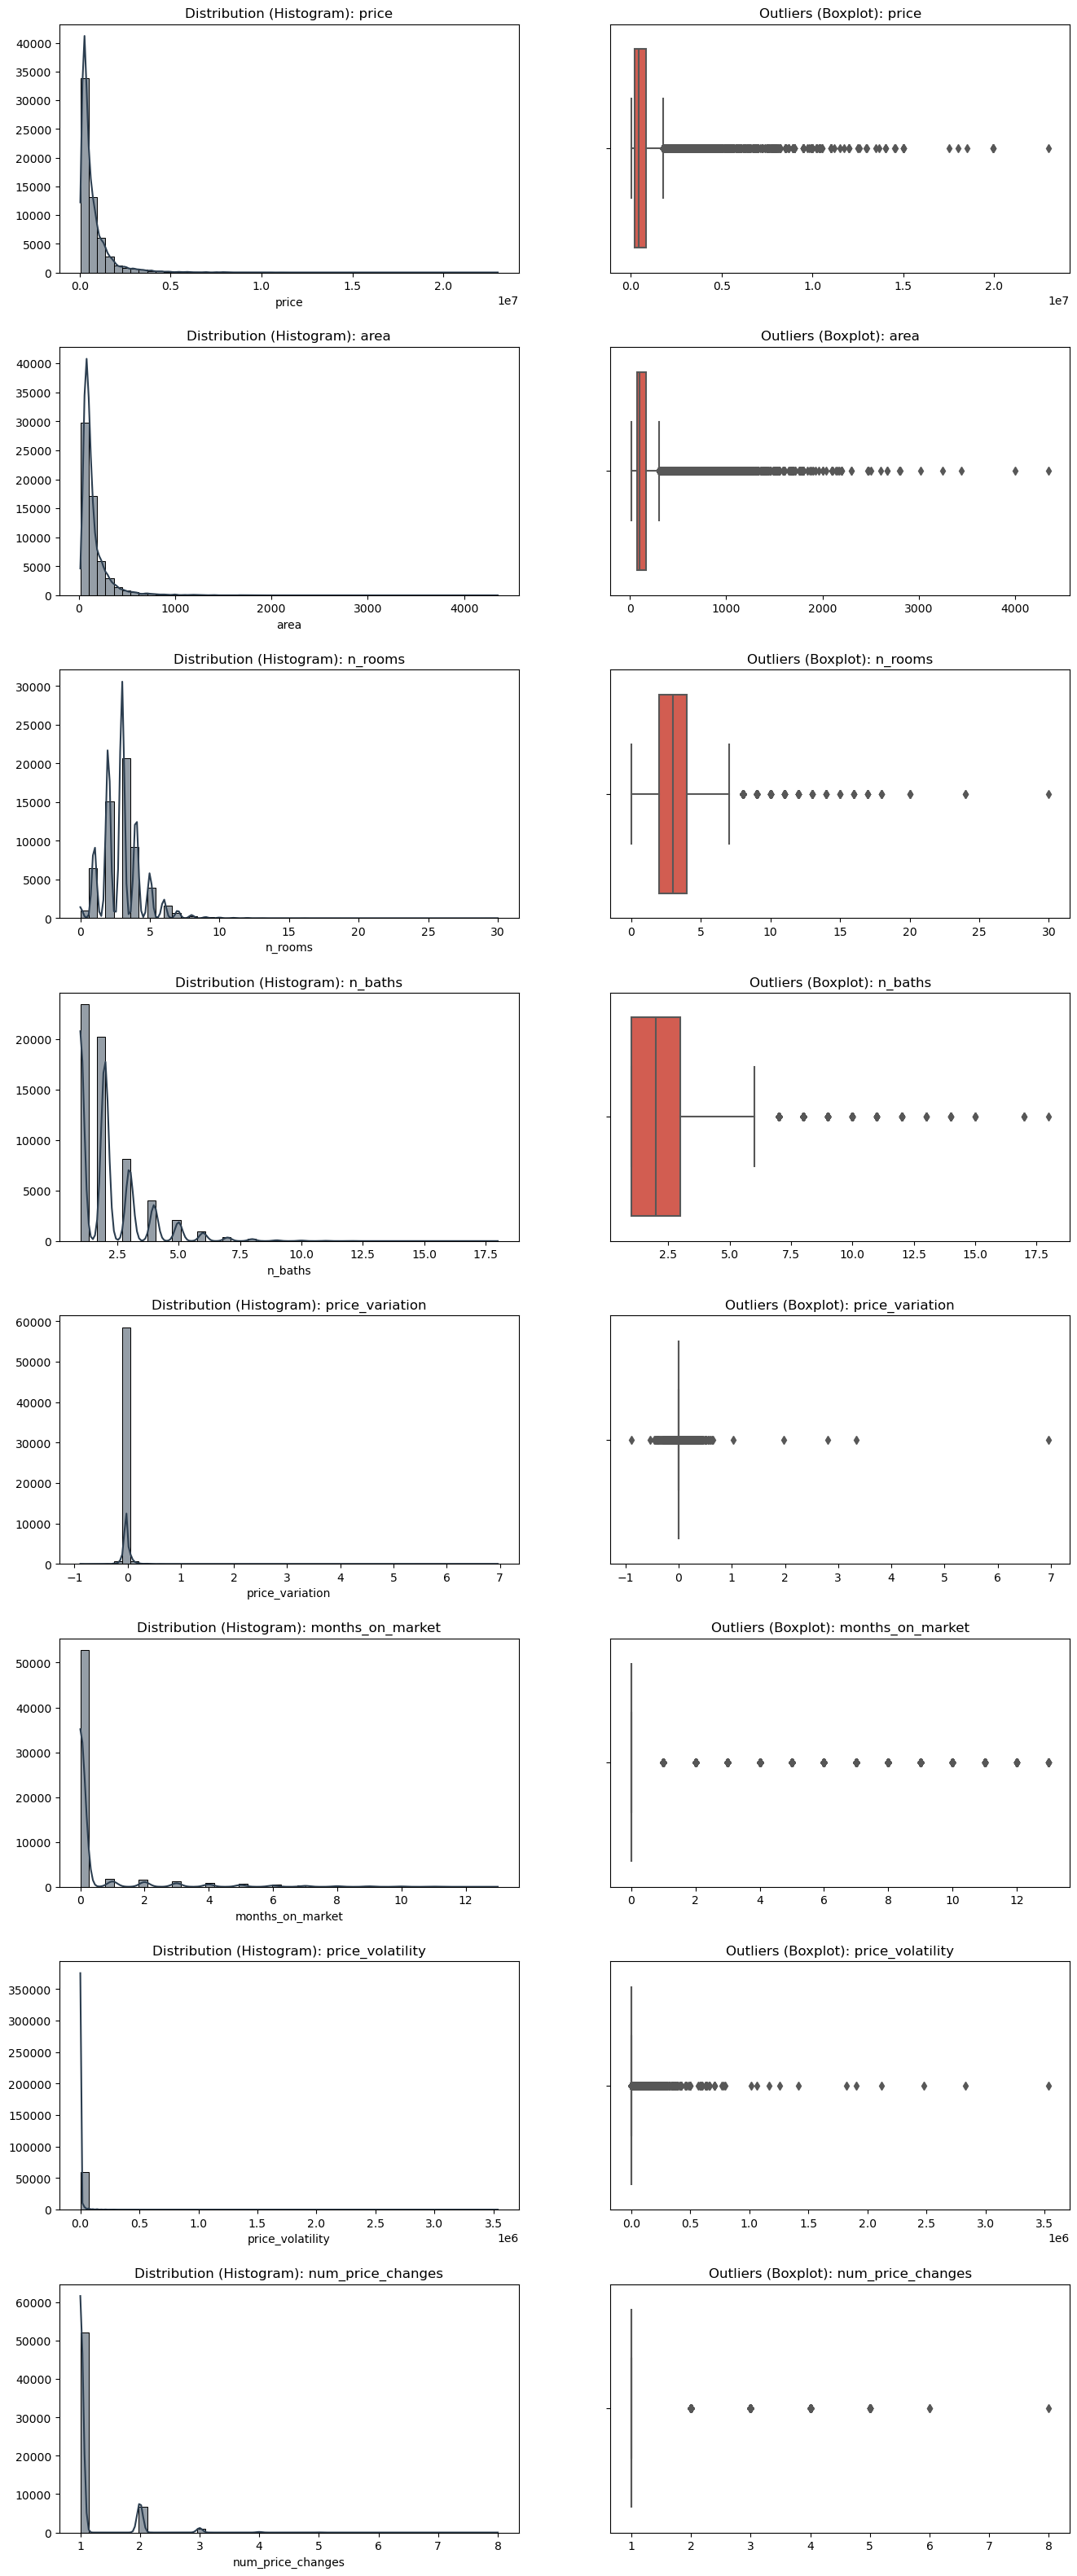

In [53]:
warnings.filterwarnings("ignore")


#UNCOMMENT TO PLOT
cols_to_plot = [
    'price', 'area', 'n_rooms', 'n_baths', 
    'price_variation', 'months_on_market', 'price_volatility', 'num_price_changes'
]

fig, axes = plt.subplots(nrows=len(cols_to_plot), ncols=2, figsize=(16, 40))
plt.subplots_adjust(hspace=0.3)

for i, col in enumerate(cols_to_plot):
    sns.histplot(data=df_vivienda_featured, x=col, kde=True, ax=axes[i, 0], color='#2C3E50', bins=50)
    axes[i, 0].set_title(f'Distribution (Histogram): {col}')
    axes[i, 0].set_ylabel('')
    
    sns.boxplot(x=df_vivienda_featured[col], ax=axes[i, 1], color='#E74C3C')
    axes[i, 1].set_title(f'Outliers (Boxplot): {col}')
    axes[i, 1].set_xlabel('')

plt.show()



MULTIVARIATE NON-GRAPHICAL ANALYSIS

We use a correlation matrix

In [54]:
target_cols = [
    'price', 'area', 'n_rooms', 'n_baths', 
    'price_variation', 'months_on_market', 'price_volatility'
]

correlation = df_vivienda_featured[target_cols].corr()

covariance = df_vivienda_featured[target_cols].cov()

print("--- PEARSON CORRELATION MATRIX ---")
print(correlation.to_string(float_format="{:.2f}".format))

print("\n--- COVARIANCE MATRIX ---")
print(covariance.to_string(float_format="{:.2f}".format))

--- PEARSON CORRELATION MATRIX ---
                  price  area  n_rooms  n_baths  price_variation  months_on_market  price_volatility
price              1.00  0.68     0.47     0.68             0.01              0.03              0.20
area               0.68  1.00     0.68     0.80            -0.01              0.06              0.18
n_rooms            0.47  0.68     1.00     0.73            -0.01              0.04              0.10
n_baths            0.68  0.80     0.73     1.00            -0.01              0.06              0.14
price_variation    0.01 -0.01    -0.01    -0.01             1.00             -0.08              0.11
months_on_market   0.03  0.06     0.04     0.06            -0.08              1.00              0.32
price_volatility   0.20  0.18     0.10     0.14             0.11              0.32              1.00

--- COVARIANCE MATRIX ---
                           price         area   n_rooms   n_baths  price_variation  months_on_market  price_volatility
price      

GLOBAL CORRELATION HEATMAP

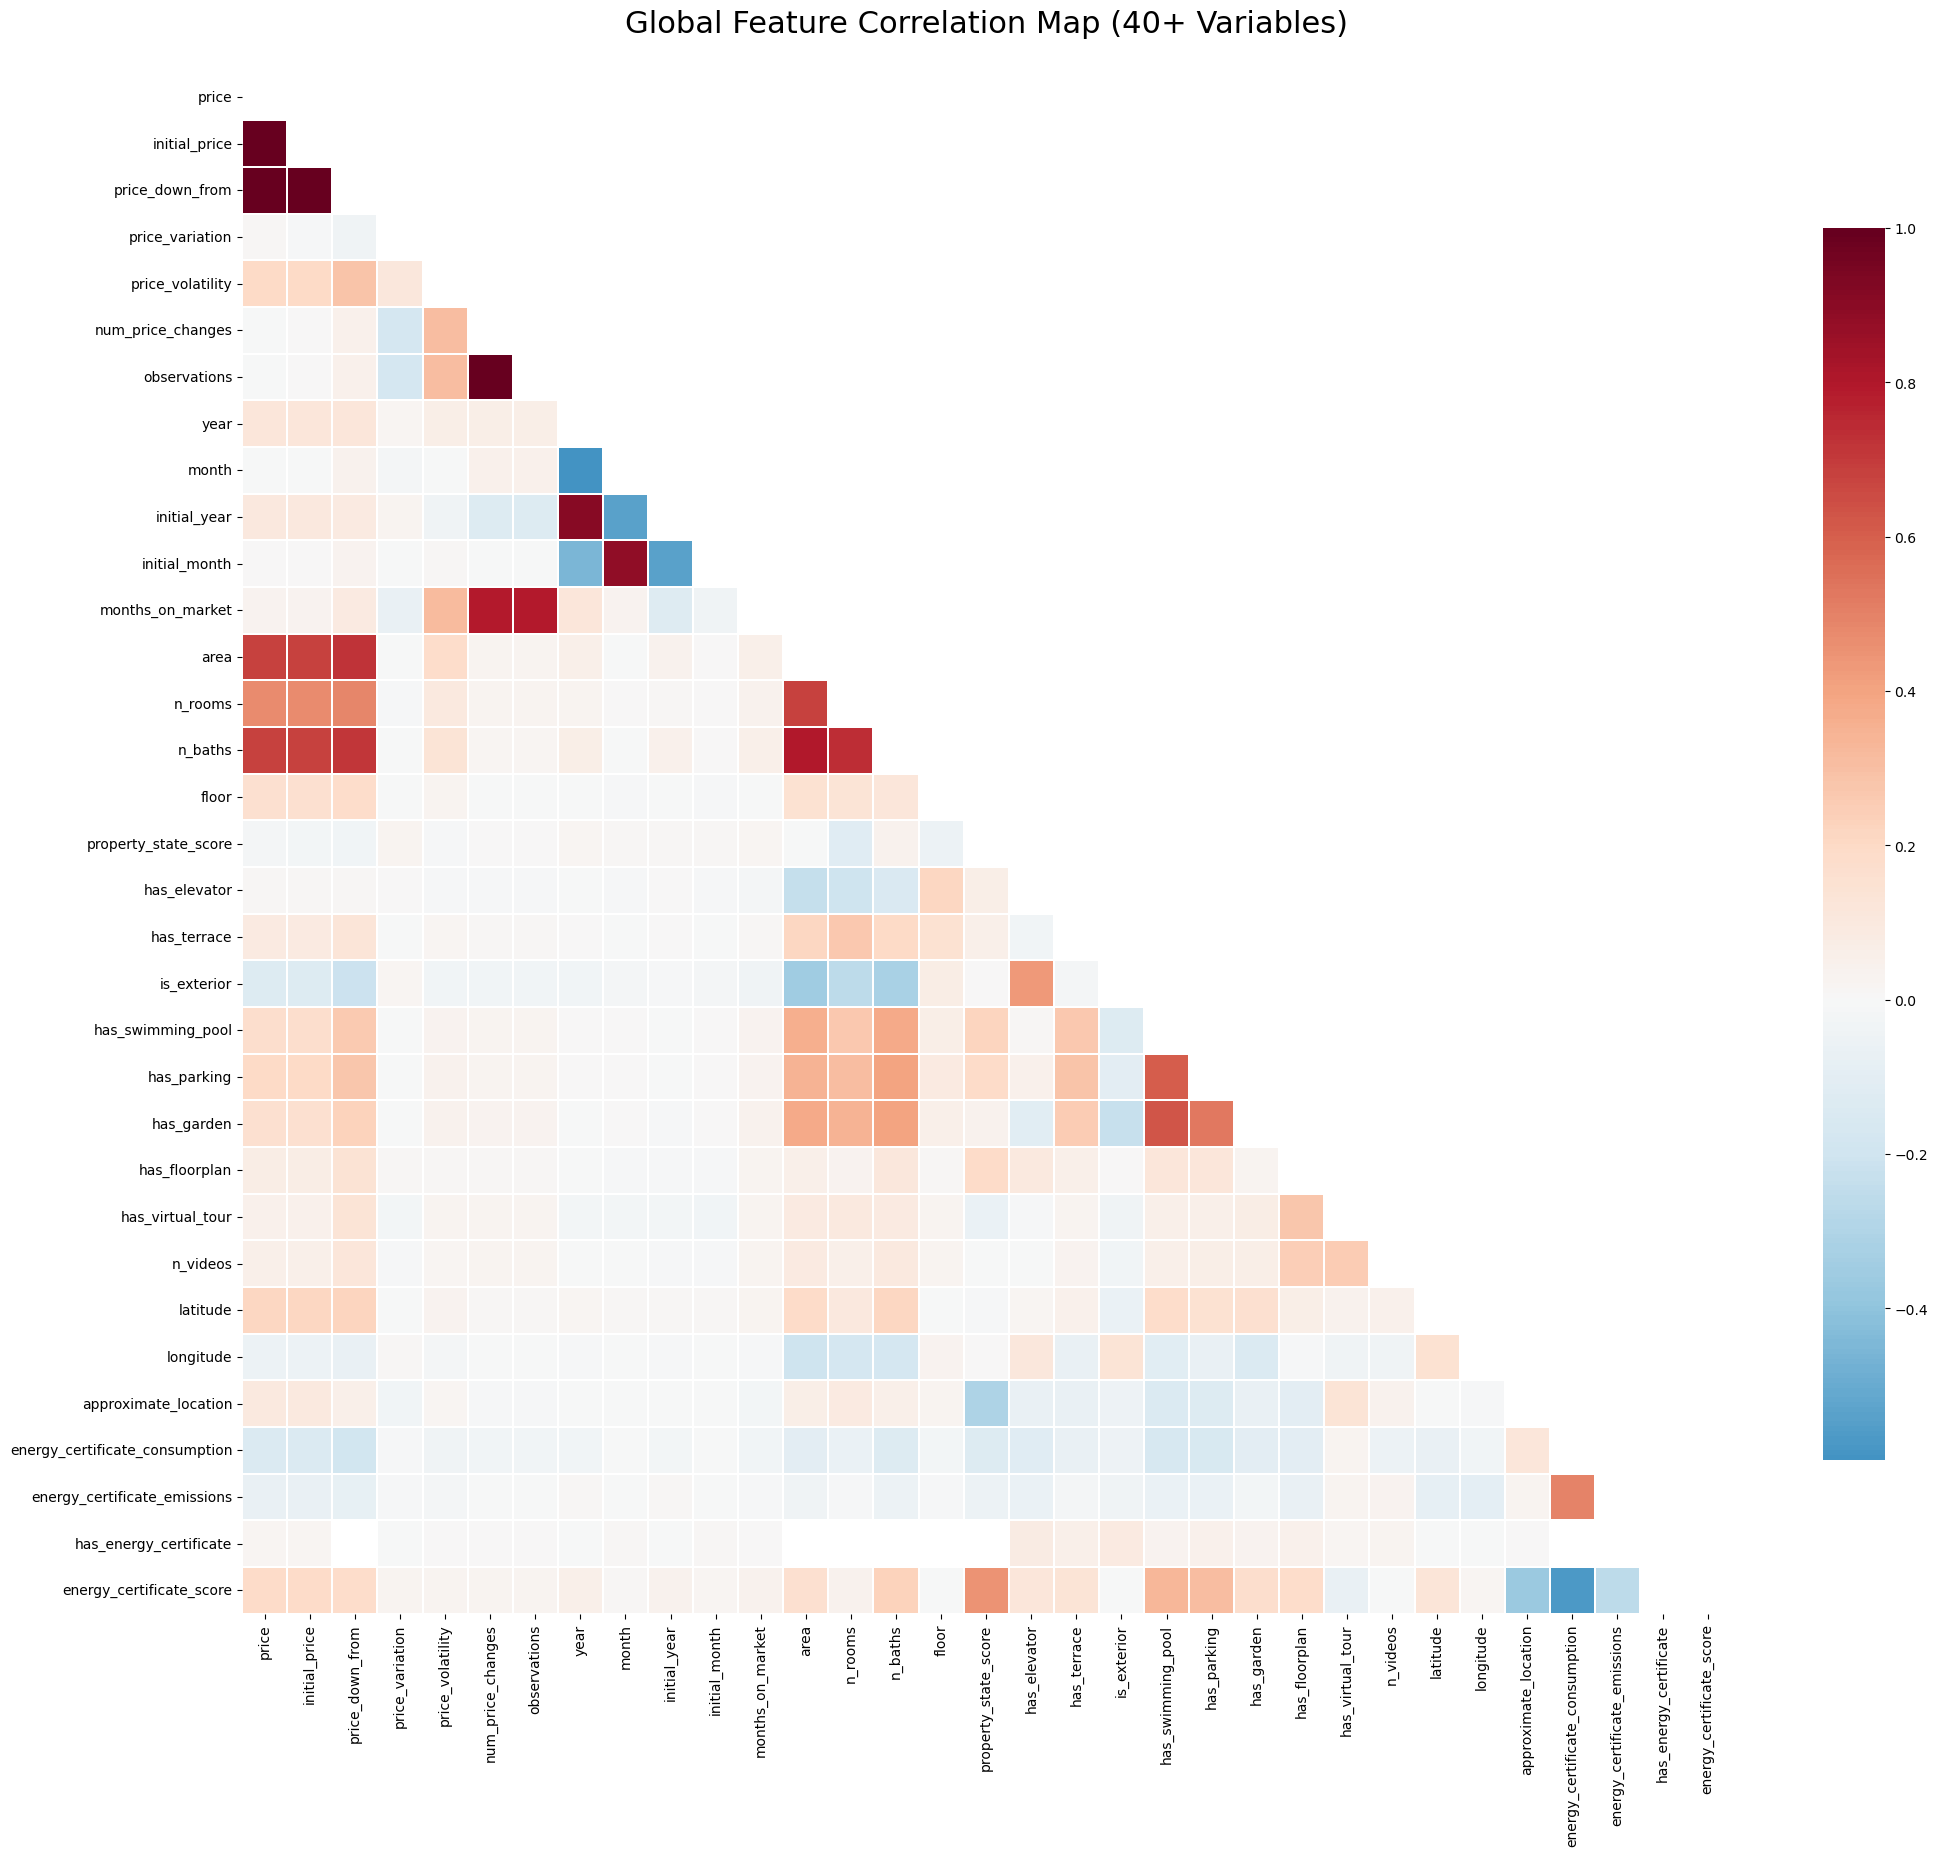

In [55]:

numeric_df = df_vivienda_featured.select_dtypes(include=[np.number])

if 'reference_id' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['reference_id'])

corr_matrix = numeric_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(24, 20))

sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=False, 
    cmap='RdBu_r', 
    center=0,
    linewidths=.1, 
    cbar_kws={"shrink": .8}
)

plt.title('Global Feature Correlation Map (40+ Variables)', fontsize=22, pad=30)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

#plt.savefig('global_heatmap.png', bbox_inches='tight')
plt.show()

We drop 'observations' feature because it has correlation 1 whith 'num_price_changes'.

In [56]:
df_vivienda_featured = df_vivienda_featured.drop(columns=['observations'])

MULTIVARIATE GRAPHICAL ANALYSIS

Scatter Matrix

We analize prizes in relationship with latitude and longitude

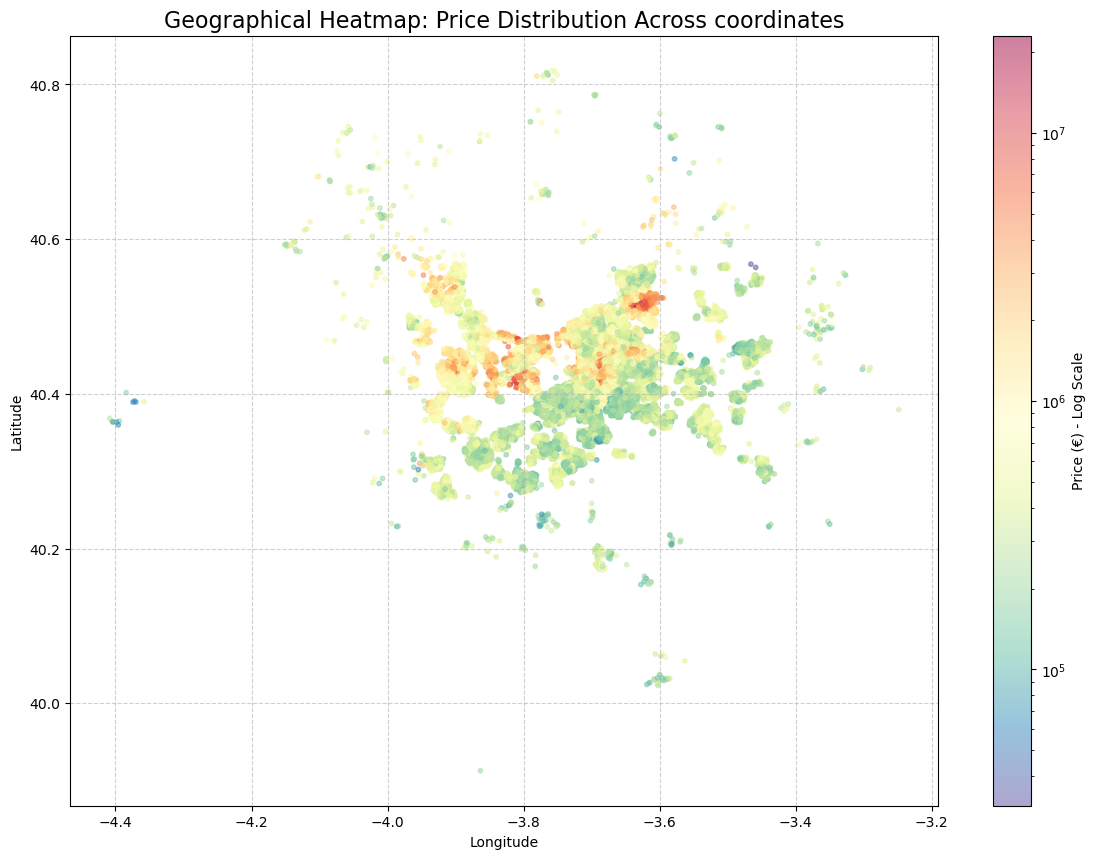

In [57]:
plt.figure(figsize=(14, 10))

scatter = plt.scatter(
    data=df_vivienda_featured,
    x='longitude',
    y='latitude',
    c='price',
    cmap='Spectral_r', 
    alpha=0.5,
    s=10, # Small point size to see the density of the city
    norm=colors.LogNorm(vmin=df_vivienda_featured['price'].min(), 
                        vmax=df_vivienda_featured['price'].max())
)

plt.colorbar(scatter, label='Price (€) - Log Scale')
plt.title('Geographical Heatmap: Price Distribution Across coordinates', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

We analize price in relation to the other features

SCATTER PLOTS

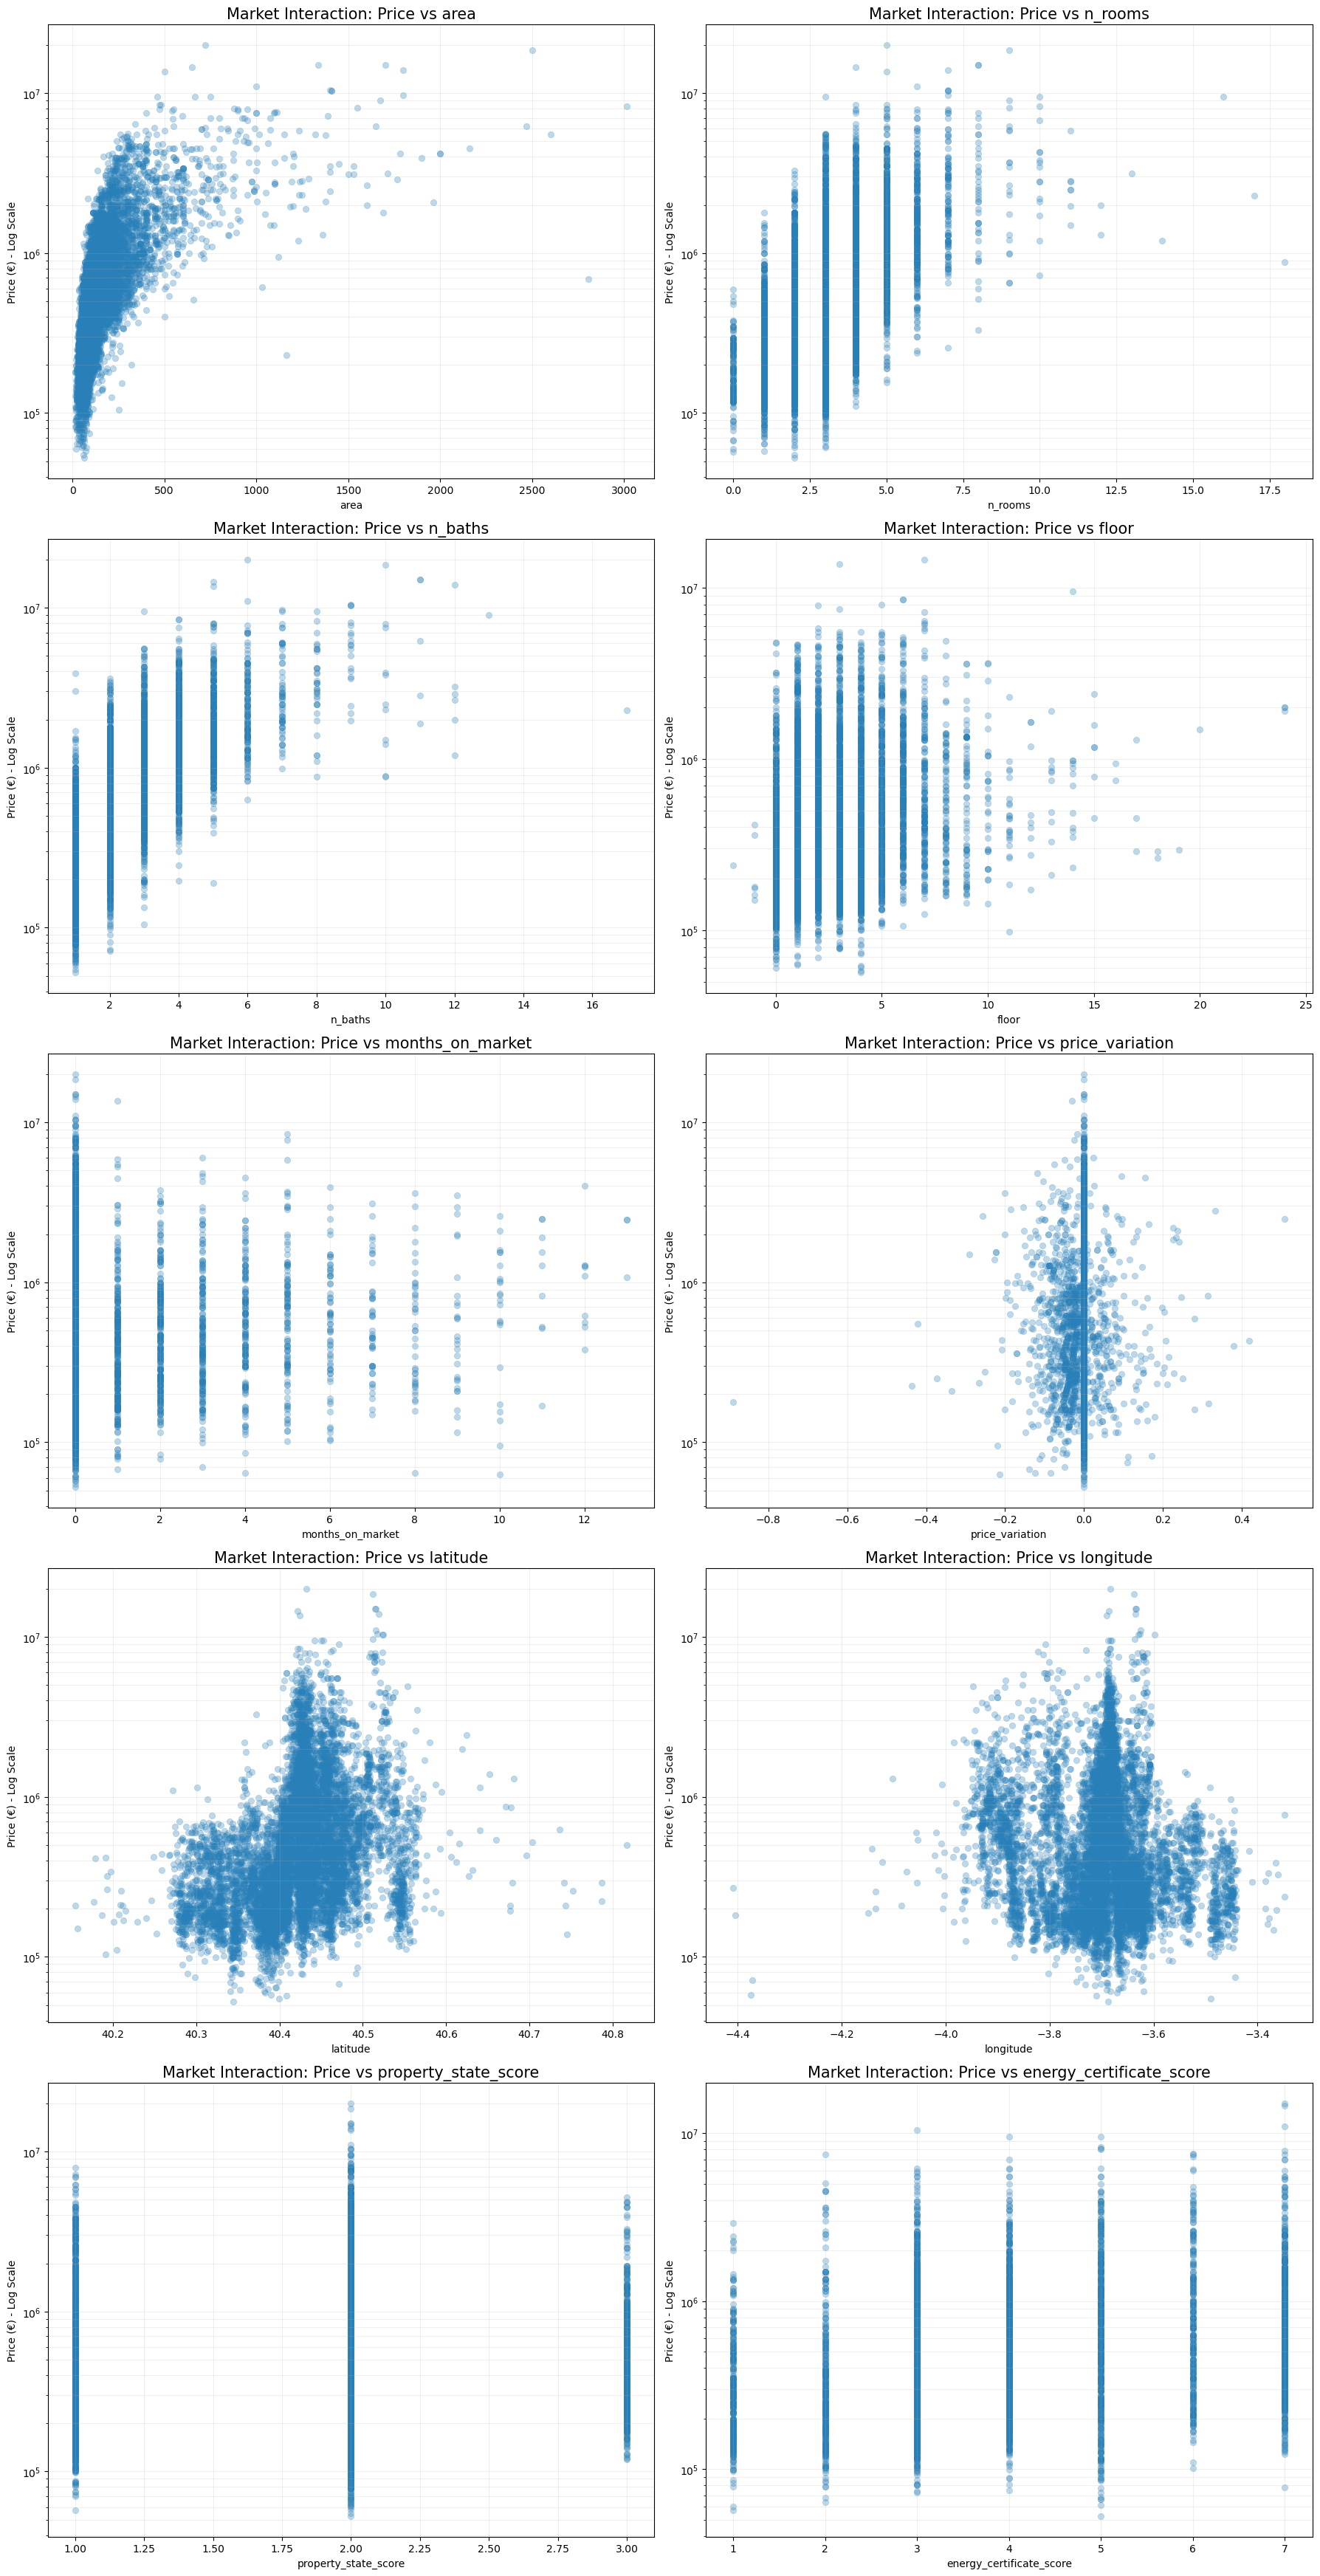

In [58]:
continuous_features = [
    'area', 'n_rooms', 'n_baths', 'floor', 
    'months_on_market', 'price_variation', 'latitude', 'longitude', 
    'property_state_score', 'energy_certificate_score'
]

# Update to 5 rows to accommodate 10 features (5*2=10)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 35))
axes = axes.flatten()

plot_data = df_vivienda_featured.sample(min(10000, len(df_vivienda_featured)))

for i, col in enumerate(continuous_features):
    sns.scatterplot(
        data=plot_data, 
        x=col, 
        y='price', 
        ax=axes[i], 
        alpha=0.3, 
        color='#2980B9',
        edgecolor=None,
        
    )
    axes[i].set_yscale('log')
    axes[i].set_title(f'Market Interaction: Price vs {col}', fontsize=15)
    axes[i].set_ylabel('Price (€) - Log Scale')
    axes[i].grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

BOX PLOTS IN BYNARY FEATURES

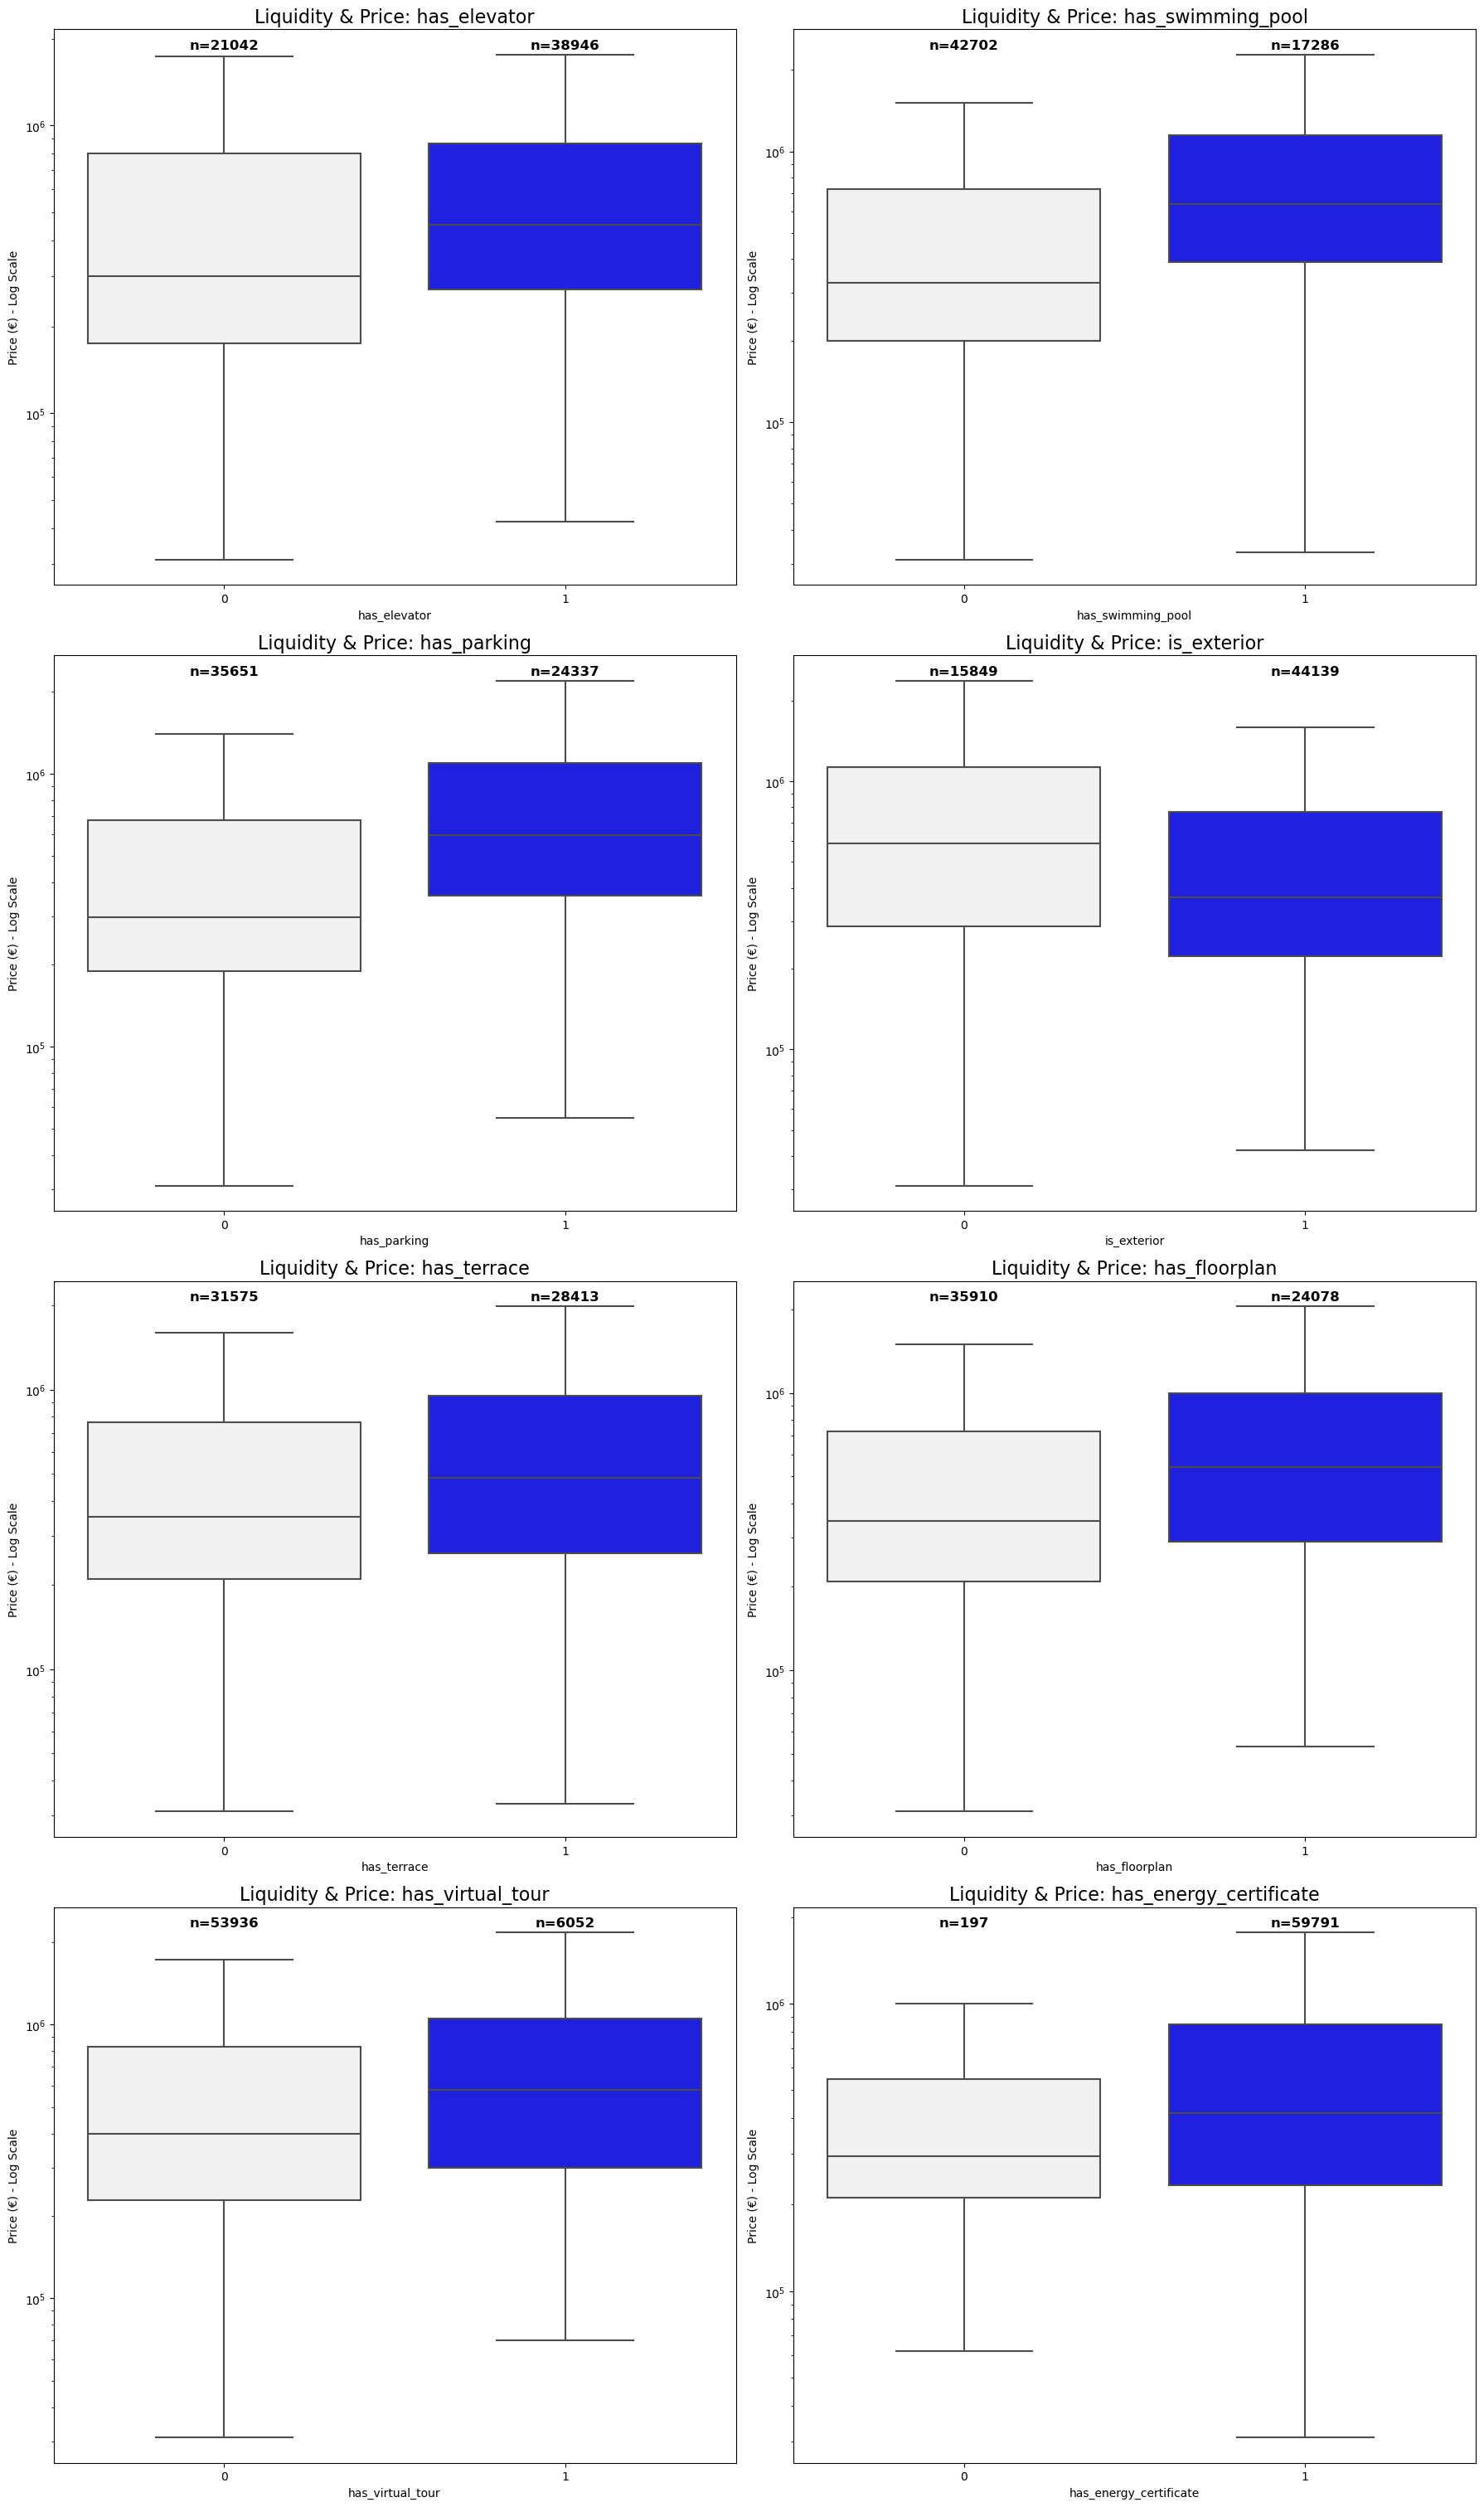

In [59]:

binary_invest_cols = [
    'has_elevator', 'has_swimming_pool', 'has_parking', 
    'is_exterior', 'has_terrace',
    'has_floorplan', 'has_virtual_tour', 'has_energy_certificate' 
]

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(18, 45))
axes = axes.flatten()

for i, col in enumerate(binary_invest_cols):
    sns.boxplot(
        data=df_vivienda_featured, 
        x=col, 
        y='price', 
        ax=axes[i], 
        palette='light:b', 
        showfliers=False, 
        zorder=1
    )
    
    current_counts = df_vivienda_featured[col].value_counts().sort_index()
    
    for xtick in axes[i].get_xticks():
        if xtick < len(current_counts):
            n_val = current_counts.iloc[xtick]
            axes[i].text(
                xtick, axes[i].get_ylim()[1], f'n={n_val}', 
                horizontalalignment='center', size='large', 
                color='black', weight='bold'
            )

    axes[i].set_yscale('log')
    axes[i].set_title(f'Liquidity & Price: {col}', fontsize=16)
    axes[i].set_ylabel('Price (€) - Log Scale')

for j in range(len(binary_invest_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

FEATURE ENGINEERING

First we introduce an important feature: price per square meter

In [60]:
df_vivienda_featured['price_m2'] = df_vivienda_featured['price'] / df_vivienda_featured['area']

We run a heatmap to see if it changes

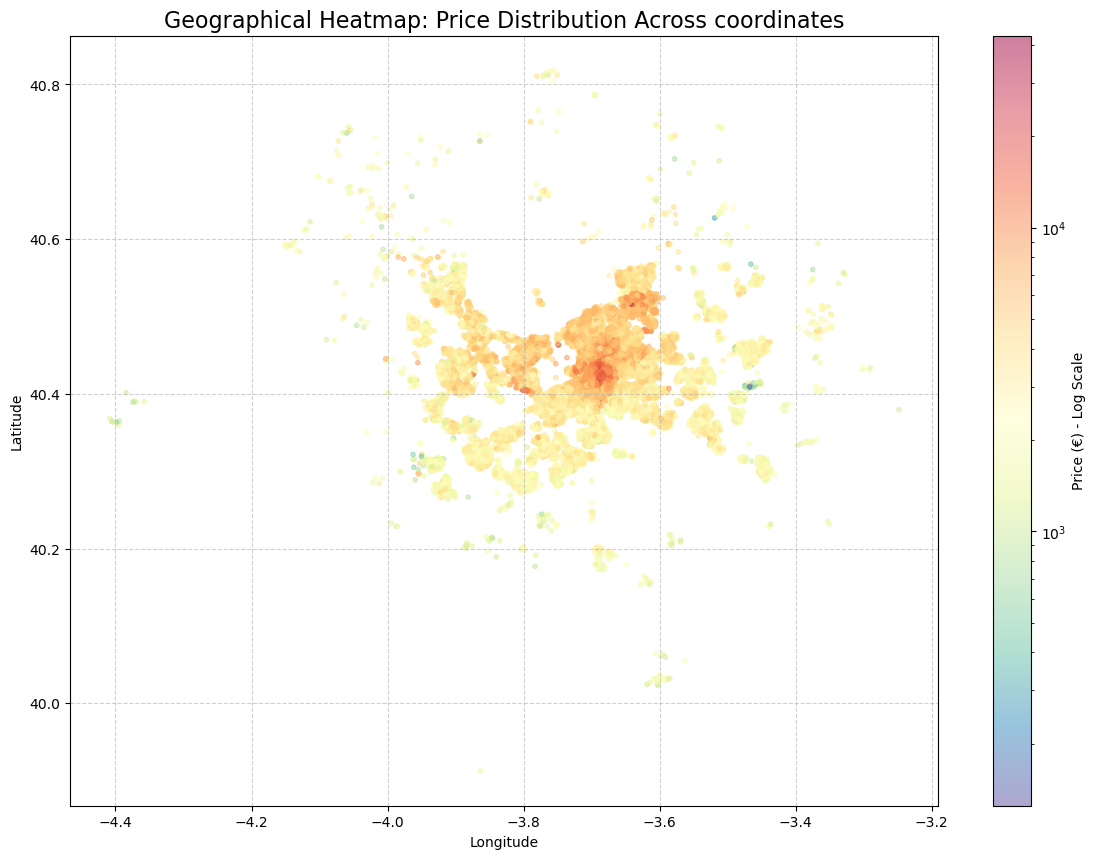

In [61]:
plt.figure(figsize=(14, 10))

scatter = plt.scatter(
    data=df_vivienda_featured,
    x='longitude',
    y='latitude',
    c='price_m2',
    cmap='Spectral_r', 
    alpha=0.5,
    s=10, # Small point size to see the density of the city
    norm=colors.LogNorm(vmin=df_vivienda_featured['price_m2'].min(), 
                        vmax=df_vivienda_featured['price_m2'].max())
)

plt.colorbar(scatter, label='Price (€) - Log Scale')
plt.title('Geographical Heatmap: Price Distribution Across coordinates', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

INTRODUCE NEW FEATURES

In [62]:

df_vivienda_featured['relative_volatility'] = df_vivienda_featured['price_volatility'] / df_vivienda_featured['price']


cols_to_clean =  'relative_volatility'
df_vivienda_featured[cols_to_clean] = df_vivienda_featured[cols_to_clean].replace([np.inf, -np.inf], 0).fillna(0)

df_vivienda_featured['avg_room_size'] = df_vivienda_featured['area'] / df_vivienda_featured['n_rooms']
df_vivienda_featured['bath_room_ratio'] = df_vivienda_featured['n_baths'] / df_vivienda_featured['n_rooms']

df_vivienda_featured['amenity_sum'] = (
    df_vivienda_featured['has_elevator'] + 
    df_vivienda_featured['has_parking'] + 
    df_vivienda_featured['has_swimming_pool'] + 
    df_vivienda_featured['has_terrace'] +
    df_vivienda_featured['has_floorplan'] +
    df_vivienda_featured['has_virtual_tour']
)

coords = df_vivienda_featured[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=50, random_state=42, n_init=10)
df_vivienda_featured['loc_cluster'] = kmeans.fit_predict(coords)

clean_cols = ['avg_room_size', 'bath_room_ratio']
df_vivienda_featured[clean_cols] = df_vivienda_featured[clean_cols].replace([np.inf, -np.inf], np.nan)
df_vivienda_featured[clean_cols] = df_vivienda_featured[clean_cols].fillna(0)

AFTER THE FEATURE ENGINEERING WE ARE READY TO TRAIN OUR MODEL

We export the file to checkpoint

In [63]:
output_folder = '../data/processed-data'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

df_vivienda_featured.to_parquet(f'{output_folder}/madrid_vivienda_sales_processed.parquet', index=False)


print(f"Files saved in: {output_folder}")
print(f"Df shape: {df_vivienda_featured.shape}")


Files saved in: ../data/processed-data
Df shape: (59988, 39)


In [64]:
general_overview(df_vivienda_featured)

Column Name                              | Type       | Missing         | Unique     | Sample Values
--------------------------------------------------------------------------------------------------------------
reference_id                             | int64      | 0 (0.0%)        | 59988      | 175162, 315919, 332409
price                                    | float64    | 0 (0.0%)        | 4997       | 795000.0, 475000.0, 180000.0
initial_price                            | float64    | 0 (0.0%)        | 5004       | 795000.0, 475000.0, 180000.0
price_down_from                          | float64    | 57053 (95.1%)   | 983        | 299000.0, 340000.0, 430000.0
price_variation                          | float64    | 0 (0.0%)        | 3941       | 0.0, 0.07777777777777778, 0.00398406374501992
price_volatility                         | float64    | 0 (0.0%)        | 1498       | 0.0, 18027.756377319947, 1414.213562373095
num_price_changes                        | int64      | 0 (0.0%)   